## March Madness ML Predictor

### Introduction
---
This is an ML initiative aimed at developing a model that forecasts the outcome of matchups in the NCAAM tournament. The project began by filtering a Kaggle dataset to include only the top 64 teams based on ESPN’s BPI and scraping ESPN for game scores and outcomes from the 2024–25 season. The target variable was defined by whether team_1 won or lost, and 26 features were created by computing the differences between the statistics of the two competing teams. The data was then split into training/validation and test sets, with a StandardScaler applied to maintain uniformity, and class imbalance was addressed using class weight adjustments.

After evaluating several models—including Decision Tree, Logistic Regression, Gradient Boosting, and Random Forest—the Random Forest model emerged as the most effective, achieving consistent accuracy around 68% on both validation and test sets, with superior precision and competitive recall. Cross-validation further confirmed its robustness, while a baseline Dummy classifier underscored the improvements made. Feature importance analysis highlighted that BPI was the most critical predictor, followed by Net Rating and Adjusted Defensive Efficiency, validating the overall approach and reinforcing the Random Forest model as the optimal choice for forecasting NCAAM tournament outcomes.

### Importing libraries
---

In [82]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier 
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from catboost import CatBoostClassifier
from collections import Counter
import matplotlib.ticker as mtick
from sklearn.model_selection import cross_val_score
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from sklearn.dummy import DummyClassifier
import matplotlib.font_manager as fm
import textwrap
import matplotlib as mpl
import time
from bs4 import BeautifulSoup
import pandas as pd
from datetime import datetime, timedelta
import warnings
from collections import Counter
from catboost import CatBoostClassifier
from sklearn.metrics import f1_score, recall_score, precision_score
from matplotlib.ticker import PercentFormatter
from selenium import webdriver
from selenium.webdriver.chrome.options import Options

In [83]:
warnings.filterwarnings("ignore")

### Data preparation 
---

In [84]:
'''
    Function to Scrap the scoreboard from Espn for a given date. 
        input: date_str - The game date string for fetching the records in the format: YYYYMMDD 
        returns list of dictonary with team names and their game scores 
'''
def scrape_scoreboard(date_str):
    url = f"https://www.espn.com/mens-college-basketball/scoreboard/_/date/{date_str}/group/50"
    print(f"Scraping URL: {url}")
    
    chrome_options = Options()
    chrome_options.add_argument("--headless")
    chrome_options.add_argument("--no-sandbox")
    chrome_options.add_argument("--disable-dev-shm-usage")
    
    driver = webdriver.Chrome(options=chrome_options)
    driver.get(url)
    
    time.sleep(5)
    
    html = driver.page_source
    driver.quit()
    
    soup = BeautifulSoup(html, 'html.parser')
    
    team_divs = soup.find_all('div', class_="ScoreCell__TeamName ScoreCell__TeamName--shortDisplayName db")
    score_divs = soup.find_all('div', class_="ScoreCell__Score h4 clr-gray-01 fw-heavy tar ScoreCell_Score--scoreboard pl2")
    
    print("Found team_divs:", len(team_divs))
    print("Found score_divs:", len(score_divs))
    
    games = []
    for i in range(0, len(team_divs), 2):
        team1 = team_divs[i].get_text(strip=True)
        team2 = team_divs[i+1].get_text(strip=True)
        
        if i+1 < len(score_divs):
            score1 = score_divs[i].get_text(strip=True)
            score2 = score_divs[i+1].get_text(strip=True)
        else:
            score1 = "N/A"
            score2 = "N/A"
        
        games.append({
            "date": date_str,
            "team1": team1,
            "team2": team2,
            "score1": score1,
            "score2": score2
        })
    return games

'''
    Function to Scrap the scoreboard from Espn for a date range
        input: start_date_str, end_date_str
          - The Start and end dates in string for fetching the game score board records in the format: YYYYMMDD 
        returns list of score boards of games played between start_date_str and end_date_str 
'''

def scrape_date_range(start_date_str, end_date_str):
    start_date = datetime.strptime(start_date_str, "%Y%m%d")
    end_date = datetime.strptime(end_date_str, "%Y%m%d")
    
    current_date = start_date
    all_games = []
    
    while current_date <= end_date:
        date_str = current_date.strftime("%Y%m%d")
        games = scrape_scoreboard(date_str)
        if games:
            all_games.extend(games)
        else:
            print(f"No games found for {date_str}.")
        current_date += timedelta(days=1)
    return all_games

'''
    One Time code to Build extract and build the dataset: 
    Uncomment the below code and set the dates as desired - It takes more time for larger date period
'''
# The date range is pointing to only one day for demonstration.
# start_date_str = "20241104"
# end_date_str   = "20241104" 

# try:
#     all_matchups = scrape_date_range(start_date_str, end_date_str)
# except:
#     print("Issue in accessing the website")

# if all_matchups:
#     df = pd.DataFrame(all_matchups)  
#     df.to_csv("ncaa_data.csv", index=False)
#     print(f"Data exported to CSV file at: ncaa_data.csv")
# else:
#     print("No matchups found for the given date range.")

'\n    One Time code to Build extract and build the dataset: \n    Uncomment the below code and set the dates as desired - It takes more time for larger date period\n'

#### For the data preparation stage, the following steps were followed:

1) The top 64 teams from ESPN were extracted based on the Basketball Power Index Rank (BPI RK).
   
3) The Kaggle dataset was filtered to include only these 64 teams for the 2025 season.
   
5) Above BeautifulSoup script was utilized to scrape the ESPN website for the scoreboard of the 2024–25 NCAA Men’s Basketball games, capturing each matchup (team_1 vs team_2) along with the game scores.
   
7) The 'winner' column, derived from the scraping process, served as the target variable, indicating whether team_1 won (class 1) or lost (class 0).

8) Features were engineered by calculating, for each matchup, the difference between the statistics of team_1 and team_2, resulting in a total of 26 features per game.

9) Features underwent selection and aggregation across two primary categories: ***Team Stats*** and ***General Info***. The Team Stats category is divided into three subcategories: (A) Efficiency & Shooting, (B) Game Dynamics & Possession, and (C) Overall Team Performance & Experience. The General Info category comprises contextual columns that do not directly reflect in-game performance but remain significant for modeling or identification. Below is an overall description of all features and the applied aggregation methods:

***Team Stats***

---
A. Efficiency & Shooting Metrics

---

**Adjusted Offensive Efficiency:**
    Points scored per 100 possessions, adjusted for opponent strength. Higher values indicate a more efficient offense.

**Adjusted Defensive Efficiency:**
    Points allowed per 100 possessions, adjusted for opponent strength. Lower values indicate a stronger defense.
    
**eFGPct (Effective Field Goal Percentage):** Adjusts field goal percentage to account for the extra value of three-point shots.

**FTRate (Free Throw Rate):** Ratio of free throw attempts to field goal attempts, indicating how frequently the team gets to the line.

**FG2Pct (2-Point Field Goal Percentage):** Success rate on two-point shots inside the arc.

**FG3Pct (3-Point Field Goal Percentage):** Success rate on shots taken from beyond the arc.

**FTPct (Free Throw Percentage):** Conversion rate on free throws.

**BlockPct (Block Percentage):** Percentage of opponent two-point shots blocked by the team.

**OppFG2Pct (Opponent 2-Point Field Goal Percentage):** Opponents’ success rate on shots inside the arc, reflecting the team’s ability to defend close-range attempts.

**OppFG3Pct (Opponent 3-Point Field Goal Percentage):** Opponents’ success rate on shots from beyond the arc, reflecting the effectiveness of the perimeter defense.

**OppFTPct (Opponent Free Throw Percentage):** Conversion rate on opponents’ free throws.

**OppBlockPct (Opponent Block Percentage):** Percentage of the team’s own two-point attempts that are blocked by opponents.

---

B. Game Dynamics & Possession Metrics

---

**Adjusted Tempo:** Estimated number of possessions per 40 minutes, adjusted for opponent, indicating the pace of play.

**TOPct (Turnover Percentage):** Percentage of possessions that end in turnovers; lower values are preferable.

**ORPct (Offensive Rebound Percentage):** Percentage of available offensive rebounds secured by the team.

**ARate (Assist Rate):** Percentage of made field goals that are assisted, reflecting team ball movement.

**StlRate (Steal Rate):** Percentage of defensive possessions that result in a steal by the team.

**OppStlRate (Opponent Steal Rate):** Percentage of the team’s offensive possessions that end in a steal by the opponent.

---

C. Overall Team Performance & Experience

--- 
**Net Rating:** Difference between offensive and defensive ratings (points scored minus points allowed per 100 possessions).

**Experience:** A measure of the team’s overall experience, often weighted by minutes played.

**W-L:** Overall win-loss record, serving as a straightforward indicator of team success.

**BPI (Basketball Power Index):** ESPN’s comprehensive power metric for the team, combining aspects of offense, defense, and pace.

---


***General Info***

---
**Active Coaching Length:** Indicates the duration of the current coach’s tenure.

**SOS RK (Strength of Schedule Rank):** Rank that reflects the overall difficulty of the team’s schedule; lower rankings denote more challenging schedules.

**NC SOS (Non-Conference Strength of Schedule):** Reflects the difficulty of non-conference games, which can differ significantly from conference play.

---



### Importing DataSet
---

In [85]:
df = pd.read_csv(r"https://raw.githubusercontent.com/ayyammal-g/march_code_jam_madness_modellers/refs/heads/main/ncaa_mens_data.csv")
print("The DataSet Dimensions Rows X Columns:" ,df.shape)
print("The Dataset Sample Records")
df.head()

The DataSet Dimensions Rows X Columns: (509, 34)
The Dataset Sample Records


,date,year,month,day,Season,team1,team2,winner,Adjusted Tempo,Adjusted Offensive Efficiency,...,StlRate,OppStlRate,Experience,Net Rating,Active Coaching Length,W,L,BPI,SOS RK,NC SOS
0,20241104,2024,11,4,2025,Baylor Bears,Gonzaga Bulldogs,0,-5.0,-4.1,...,0.0,0.0,-0.3,-7.0,-4,-5,4,-2.3,-66,42
1,20241104,2024,11,4,2025,Ohio State Buckeyes,Texas Longhorns,1,0.1,1.4,...,0.0,0.0,-0.7,3.5,-2,0,0,0.0,-42,-197
2,20241104,2024,11,4,2025,Missouri Tigers,Memphis Tigers,0,-2.3,11.4,...,0.0,0.0,-0.5,9.3,-4,-4,4,1.9,10,311
3,20241108,2024,11,8,2025,North Carolina Tar Heels,Kansas Jayhawks,0,2.1,3.8,...,0.0,0.0,-1.4,-6.0,-18,1,0,-2.8,24,-8
4,20241108,2024,11,8,2025,New Mexico Lobos,UCLA Bruins,1,8.4,-2.8,...,0.0,0.0,0.2,-4.4,-2,3,-3,-3.5,36,-133


In [86]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 509 entries, 0 to 508
Data columns (total 34 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   date                           509 non-null    int64  
 1   year                           509 non-null    int64  
 2   month                          509 non-null    int64  
 3   day                            509 non-null    int64  
 4   Season                         509 non-null    int64  
 5   team1                          509 non-null    object 
 6   team2                          509 non-null    object 
 7   winner                         509 non-null    int64  
 8   Adjusted Tempo                 509 non-null    float64
 9   Adjusted Offensive Efficiency  509 non-null    float64
 10  Adjusted Defensive Efficiency  509 non-null    float64
 11  eFGPct                         509 non-null    float64
 12  TOPct                          509 non-null    flo

### Data Preparation
---

#### Check for Duplicates:

With the Feature engineered columns that has aggregated team stats, we will do further checks and updates to prepare the data for further analysis.

In [87]:
print(f"Duplicates: {df.drop(['winner', 'date', 'year', 'month', 'day'], axis=1).duplicated().sum()}") 

Duplicates: 0


#### Check for Missing Values:

In [88]:
print(f"Number of Columns with missing values: {df.isna().sum().sum()}")

Number of Columns with missing values: 0


In [89]:
# For the Team statistics since only 2025 season is considered, the date metrics are not required. Hence removed from the data set.
df = df.drop(['date', 'year', 'month', 'day','Season'],axis=1)
df.head()

,team1,team2,winner,Adjusted Tempo,Adjusted Offensive Efficiency,Adjusted Defensive Efficiency,eFGPct,TOPct,ORPct,FTRate,...,StlRate,OppStlRate,Experience,Net Rating,Active Coaching Length,W,L,BPI,SOS RK,NC SOS
0,Baylor Bears,Gonzaga Bulldogs,0,-5.0,-4.1,2.9,-4.4,2.9,2.0,0.9,...,0.0,0.0,-0.3,-7.0,-4,-5,4,-2.3,-66,42
1,Ohio State Buckeyes,Texas Longhorns,1,0.1,1.4,-2.1,0.8,1.4,-0.9,-0.3,...,0.0,0.0,-0.7,3.5,-2,0,0,0.0,-42,-197
2,Missouri Tigers,Memphis Tigers,0,-2.3,11.4,2.1,2.6,-3.7,-0.5,9.3,...,0.0,0.0,-0.5,9.3,-4,-4,4,1.9,10,311
3,North Carolina Tar Heels,Kansas Jayhawks,0,2.1,3.8,9.8,1.1,-1.3,-0.3,11.8,...,0.0,0.0,-1.4,-6.0,-18,1,0,-2.8,24,-8
4,New Mexico Lobos,UCLA Bruins,1,8.4,-2.8,1.6,-1.7,-0.1,-0.7,4.5,...,0.0,0.0,0.2,-4.4,-2,3,-3,-3.5,36,-133


#### Checking dataset has matchups for all 64 teams

In [90]:
# Check number of teams in column team_1 (64 teams in total)
print(df['team1'].nunique())

64



### Exploratory Data Analysis

First let us start our analysis by looking if the dataset is balanced.

#### Check for Class Imbalance:

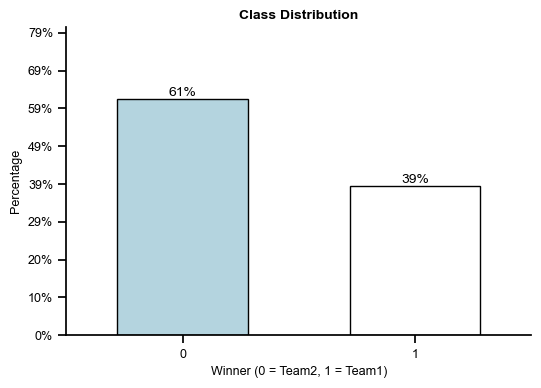

In [91]:
lost = (df['winner']==0)
won = (df['winner']==1)
ratio = lost.sum() / len(df['winner']) * 100

mpl.rcParams["font.family"] = "sans-serif"
mpl.rcParams["font.sans-serif"] = ["Arial", "Helvetica", "DejaVu Sans", "Bitstream Vera Sans"]
sns.set_context("notebook", font_scale=1)

plt.figure(figsize=(6, 4))
ax = sns.countplot(x=df["winner"], palette=["lightblue", "white"])
total = df["winner"].count()

for patch in ax.patches:
    patch.set_edgecolor('black')  
    current_width = patch.get_width()
    new_width = current_width * 0.7
    diff = current_width - new_width
    patch.set_width(new_width)
    patch.set_x(patch.get_x() + diff * 0.5)
    
    height = patch.get_height()
    percentage = height / total * 100
    ax.text(patch.get_x() + new_width / 2, height, f"{percentage:.0f}%", 
            ha='center', va='bottom', fontsize=10)

plt.title("Class Distribution", fontsize=10, fontweight='bold')
plt.xlabel("Winner (0 = Team2, 1 = Team1)", fontsize=9)
plt.ylabel("Percentage", fontsize=9)
plt.xticks(fontsize=9)
plt.yticks(fontsize=9)

plt.ylim(0, total * 0.8)
ax.yaxis.set_major_formatter(PercentFormatter(total, decimals=0))

sns.despine()
plt.show()

The dataset exhibits a class imbalance, with more instances of class 0 (team_1 lost) than class 1. This imbalance will be addressed during model training.

##### Heat Map with specific team features

With the original dataset with team specific information let us plot the heat map to see how they are correlated.

In [92]:
df_before_feature_engineering = pd.read_csv("https://raw.githubusercontent.com/ayyammal-g/march_code_jam_madness_modellers/refs/heads/main/ncaa_mens_raw_data.csv")

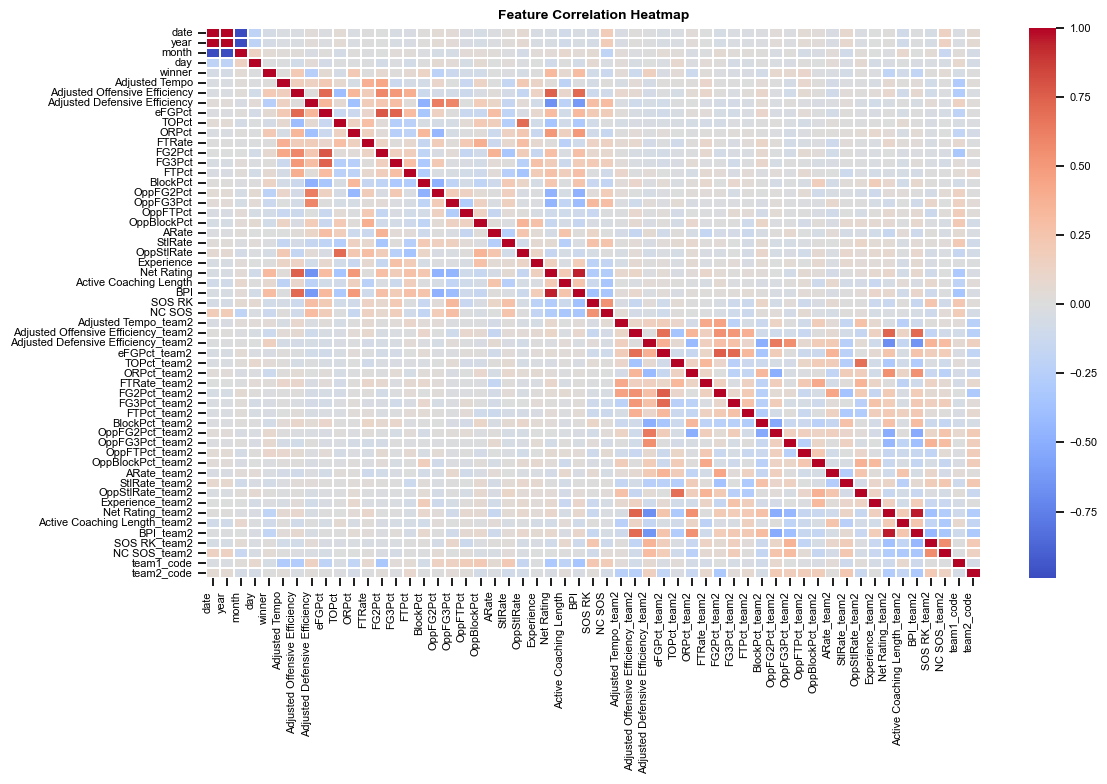

In [93]:
df_before_feature_engineering['team1_code'] = df_before_feature_engineering['team1'].astype('category').cat.codes
df_before_feature_engineering['team2_code'] = df_before_feature_engineering['team2'].astype('category').cat.codes

numeric_df = df_before_feature_engineering.select_dtypes(include=[np.number])
corr_matrix = numeric_df.corr()

plt.figure(figsize=(12, 8))
ax = sns.heatmap(corr_matrix, annot=False, cmap="coolwarm", linewidths=0.5)
plt.title("Feature Correlation Heatmap", fontsize=10, fontweight='bold')
num_cols = corr_matrix.shape[1]
num_rows = corr_matrix.shape[0]
ax.set_xticks(np.arange(num_cols) + 0.5)
ax.set_xticklabels(corr_matrix.columns, rotation=90, ha='right', fontsize=8)
ax.set_yticks(np.arange(num_rows) + 0.5)
ax.set_yticklabels(corr_matrix.index, rotation=0, fontsize=8)
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=8)

plt.tight_layout()
plt.show()


- The above heatmap illustrates the correlations among the features prior to our feature engineering step (subtracting one from the other). Some variables like Net Rating and BPI have strong collinearity between themselves. But none of them heavily correlated to Winner which might lead to Model to perform poorly.
- To efficiently illustrate the team matchups, the features were aggregated by taking difference of these metrics in our feature engineered data set. The heatmap of the engineered features to the target variable "winner" is shown below.


##### Heat Map with Aggregated Features

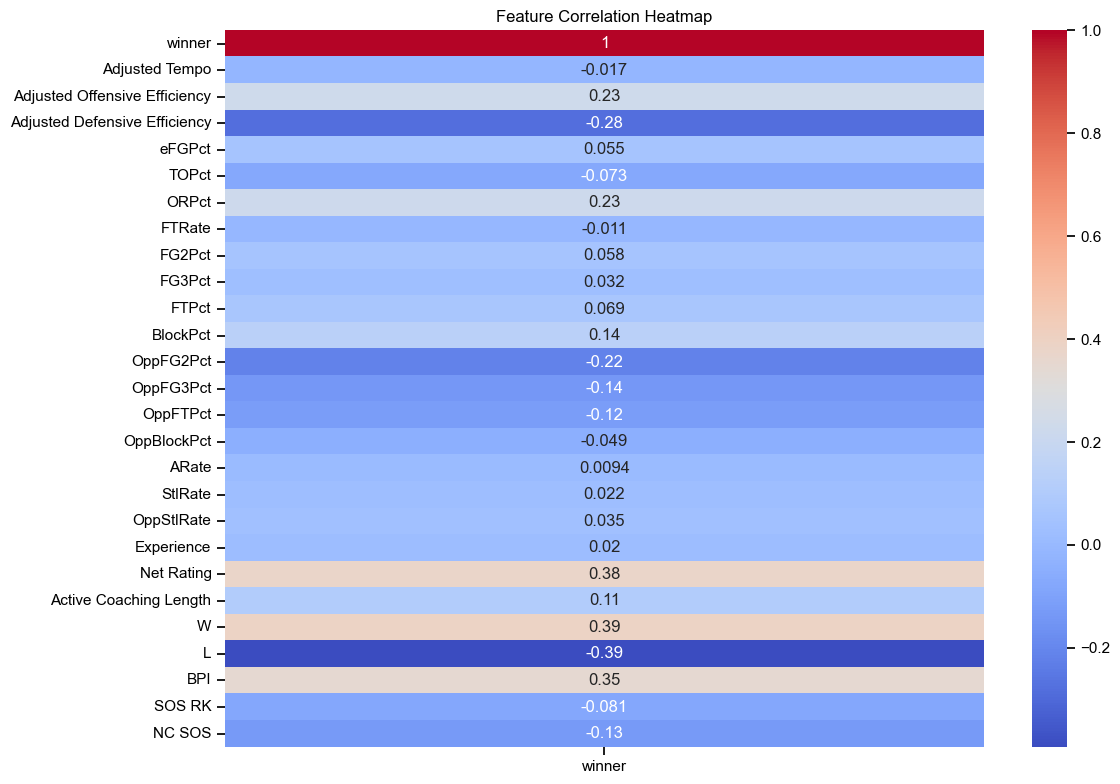

In [94]:


numeric_df = df.select_dtypes(include=[np.number])
corr_matrix = numeric_df.corr()
plt.figure(figsize=(12, 8))
ax = sns.heatmap(corr_matrix[["winner"]], annot=True, cmap="coolwarm")
plt.title("Feature Correlation Heatmap")
plt.tight_layout()
plt.show()


##### Observations:
- BPI, Net Rating and Wins are positively correlated to the winner
- Loss, Adjusted Defensive efficiency, Opponent Field Goal Percents are negatively correlated to the winner
- The heatmap clearly shows weaker opponent teams with lower defensive efficiency and low field goal percents contribute to the win.
<br></br>
<i>Note:
    Date, Month and Year are highly correlated to target but can be ignored as they represent the same season
</i>

##### Data Spread across Teams

Provided the dataset of all the team matchups, let us see how many records per team are available for Team1 and Team2.

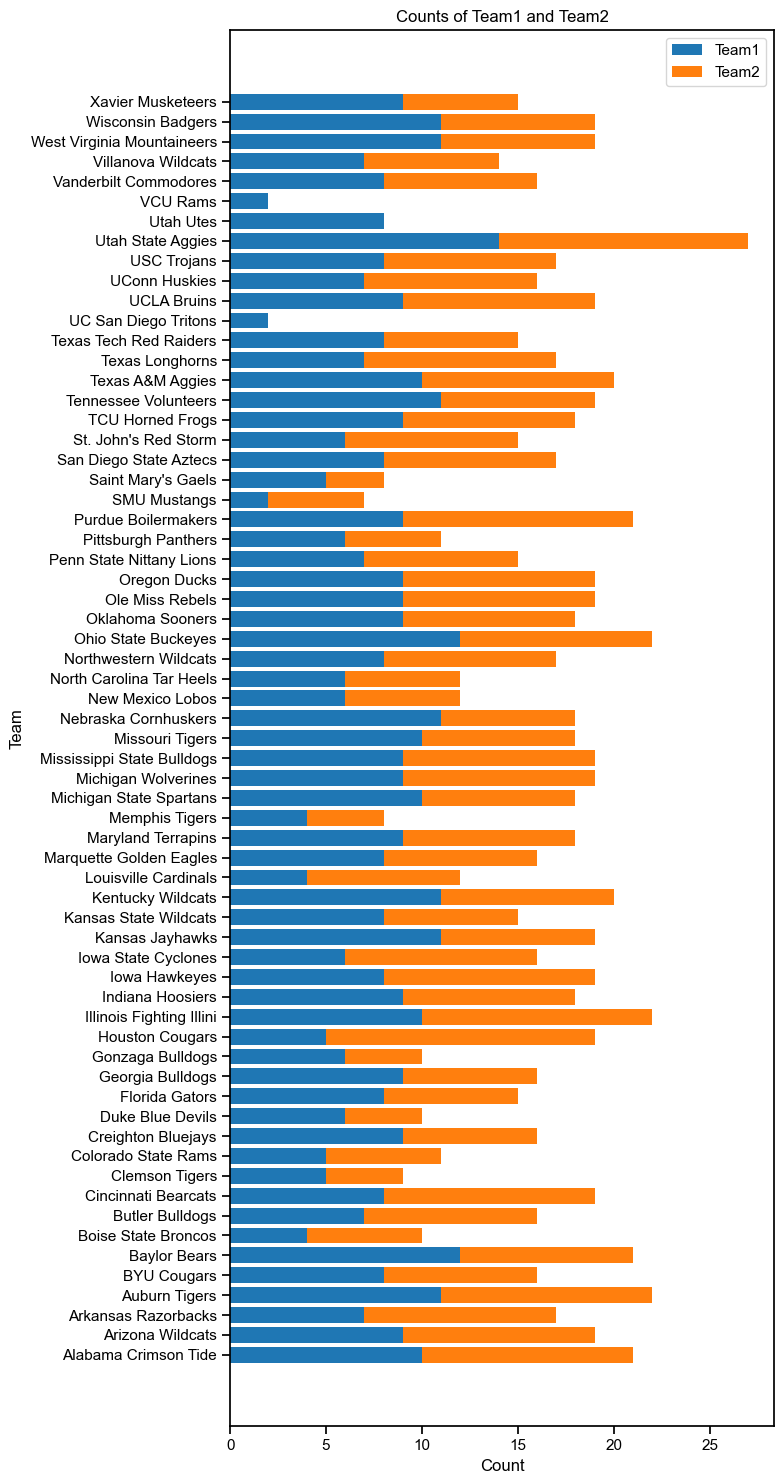

In [95]:
# Count the number of records for each team
team1_counts = df['team1'].value_counts()
team2_counts = df['team2'].value_counts()

# Get the unique teams
unique_teams = np.unique(np.concatenate((team1_counts.index, team2_counts.index)))

# Initialize the count arrays
team1_count_array = np.zeros(len(unique_teams))
team2_count_array = np.zeros(len(unique_teams))

# Populate the count arrays
for i, team in enumerate(unique_teams):
    team1_count_array[i] = team1_counts.get(team, 0)
    team2_count_array[i] = team2_counts.get(team, 0)

# Plot the counts
bar_width = 0.8
x = np.arange(len(unique_teams))
plt.figure(figsize=(8, 15))
plt.barh(x, team1_count_array, bar_width, label='Team1')
plt.barh(x, team2_count_array, bar_width, left=team1_count_array, label='Team2')
plt.yticks(x, unique_teams)
plt.xlabel('Count')
plt.ylabel('Team')
plt.title('Counts of Team1 and Team2')
plt.legend()
plt.tight_layout()
plt.show()

We Observe frome the above plot,
- Each team has 2-14 records per Team1/Team2
- Utah State Aggies has highest number of records both in Team1 and Team2
- Houston Cougers has more entries with Team2 appearance than Team1.

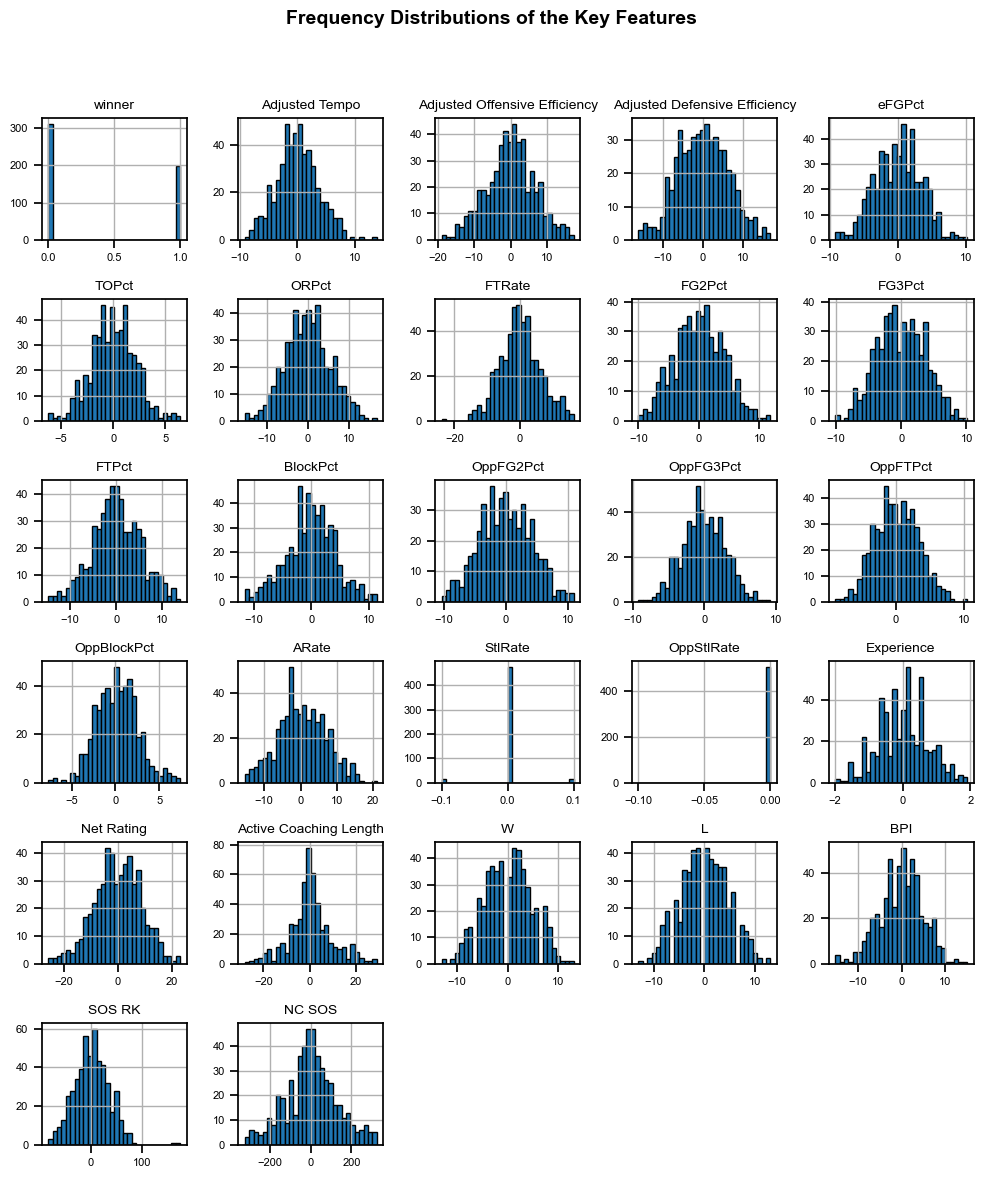

In [96]:
# Let us plot the frequency distribution of key features
axes = numeric_df.hist(figsize=(10, 12), bins=30, edgecolor='black')
for ax in axes.flatten():
    ax.set_title(ax.get_title(), fontsize=10)  
    ax.set_xlabel(ax.get_xlabel(), fontsize=8)
    ax.set_ylabel(ax.get_ylabel(), fontsize=8)
    ax.tick_params(axis='both', labelsize=8)
plt.suptitle("Frequency Distributions of the Key Features", fontsize=14, fontweight='bold')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

- Most Features are in normal distribution


##### Team Performances by Net Rating

Now that we have the aggregated features, let us see the Top 20 team match ups based on Net Rating

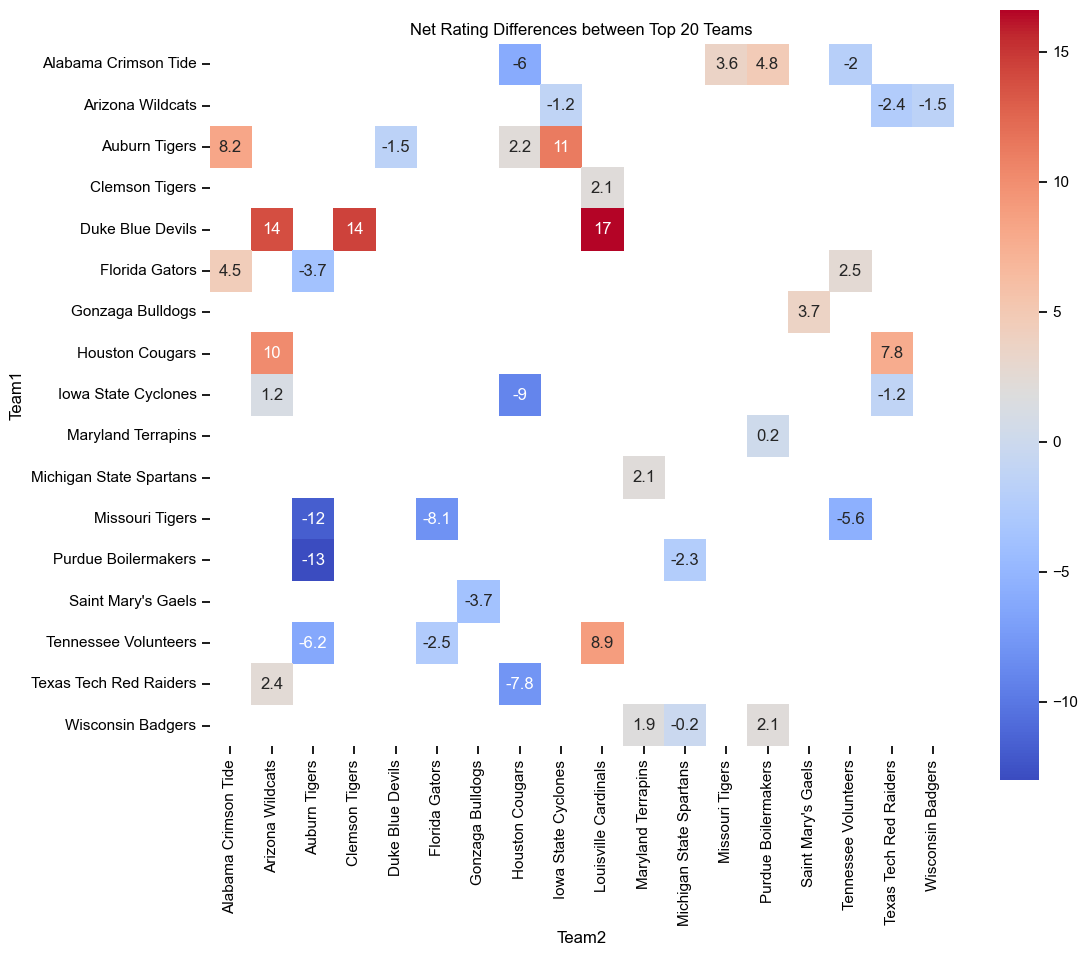

In [97]:

# Get top 20 teams by Net Rating
top_teams = df.groupby('team1')['Net Rating'].mean().sort_values(ascending=False).head(20).index
top_teams
# Filter df to only include top 20 teams in both Team1 and Team2
df_filtered = df[(df['team1'].isin(top_teams)) & (df['team2'].isin(top_teams))]

# Create a pivot table to aggregate the data
pivot_df = pd.pivot_table(df_filtered, values='Net Rating', index='team1', columns='team2')

# Create a heatmap
plt.figure(figsize=(12,10))
sns.heatmap(pivot_df, annot=True, cmap='coolwarm', square=True)
plt.title('Net Rating Differences between Top 20 Teams')
plt.xlabel('Team2')
plt.ylabel('Team1')
plt.show()

##### Findings:

- Out 64 Teams, the above 20 teams represent top performing teams based on Net Ratings
- Duke Blue Devils is topping the list with highest Net Ratings across other teams in the top20 it played with
- Houston Cougers and Auburn Tigers comes next to Duke Blue Devils
- Missouri Tigers is the poorly performing team with negative net ratings with all the teams it played with
- Alabama Crimson Tide team has inconsistent net ratings across teams.

### Model Training and Validation
---

#### Creating features/target and scalling

In [61]:
df.head(5)

,team1,team2,winner,Adjusted Tempo,Adjusted Offensive Efficiency,Adjusted Defensive Efficiency,eFGPct,TOPct,ORPct,FTRate,...,StlRate,OppStlRate,Experience,Net Rating,Active Coaching Length,W,L,BPI,SOS RK,NC SOS
0,Baylor Bears,Gonzaga Bulldogs,0,-5.0,-4.1,2.9,-4.4,2.9,2.0,0.9,...,0.0,0.0,-0.3,-7.0,-4,-5,4,-2.3,-66,42
1,Ohio State Buckeyes,Texas Longhorns,1,0.1,1.4,-2.1,0.8,1.4,-0.9,-0.3,...,0.0,0.0,-0.7,3.5,-2,0,0,0.0,-42,-197
2,Missouri Tigers,Memphis Tigers,0,-2.3,11.4,2.1,2.6,-3.7,-0.5,9.3,...,0.0,0.0,-0.5,9.3,-4,-4,4,1.9,10,311
3,North Carolina Tar Heels,Kansas Jayhawks,0,2.1,3.8,9.8,1.1,-1.3,-0.3,11.8,...,0.0,0.0,-1.4,-6.0,-18,1,0,-2.8,24,-8
4,New Mexico Lobos,UCLA Bruins,1,8.4,-2.8,1.6,-1.7,-0.1,-0.7,4.5,...,0.0,0.0,0.2,-4.4,-2,3,-3,-3.5,36,-133


As Team Names may mislead the model, they are removed along with the Target Variables for the input features to the model. 

In [62]:
features = df.drop(columns=['winner', 'team1', 'team2'])  
target = df['winner']

features_train_valid, features_test, target_train_valid, target_test = train_test_split(
    features, target, test_size=0.20, random_state=12345
)

features_train, features_valid, target_train, target_valid = train_test_split(
    features_train_valid, target_train_valid, test_size=0.25, random_state=12345
)

features_train = features_train.copy()
features_valid = features_valid.copy()
features_test = features_test.copy()

scaler = StandardScaler()
scaler.fit(features_train)

features_train = scaler.transform(features_train)
features_valid = scaler.transform(features_valid)
features_test = scaler.transform(features_test)

print("Data preprocessing completed successfully!")

Data preprocessing completed successfully!


In this step, the dataset is first split into features and the target variable ("winner"). Then, it is divided into training/validation and testing sets, with 80% of the data used for training/validation and 20% for testing. A StandardScaler is fitted on the training features and applied to all sets to ensure consistent scaling across the data.

#### Decision Tree

In [63]:
best_score = 0
best_depth = 0
rs_decision_tree = 0 
ps_decision_tree = 0

for depth in range(1, 5):
    model = DecisionTreeClassifier(random_state=12345, max_depth=depth, class_weight='balanced') 
    model.fit(features_train, target_train)
    predictions_valid_decision_tree = model.predict(features_valid)
    
    f1_decision_tree = f1_score(target_valid, predictions_valid_decision_tree)    
    
    if f1_decision_tree > best_score:
        best_score = f1_decision_tree
        best_depth = depth
        rs_decision_tree = recall_score(target_valid, predictions_valid_decision_tree)
        ps_decision_tree = precision_score(target_valid, predictions_valid_decision_tree, zero_division=0)
        score_decision_tree_train = model.score(features_train, target_train)
        score_decision_tree_valid = model.score(features_valid, target_valid)
        
print(f"Best model: max_depth = {best_depth}, F1 score: {f1_decision_tree * 100:.2f}%")
print(f"Score Train: {score_decision_tree_train* 100:.2f}%, Score Valid: {score_decision_tree_valid* 100:.2f}%")
print(f"Recall score: {rs_decision_tree* 100:.2f}%")
print(f"Precision score: {ps_decision_tree* 100:.2f}%")

Best model: max_depth = 1, F1 score: 52.17%
Score Train: 64.59%, Score Valid: 53.92%
Recall score: 91.18%
Precision score: 41.33%


#### Random Forest

In [64]:
best_score = 0
best_depth = 0
best_est = 0
best_split = 0
best_leaf = 0

for depth in [5, 10]:  
    for est in [50, 100]: 
        for split in [2, 3]:  
            for leaf in [1, 2]: 
                model = RandomForestClassifier(
                    random_state=12345, max_depth=depth, class_weight='balanced',
                    n_estimators=est, min_samples_leaf=leaf, min_samples_split=split
                )

                model.fit(features_train, target_train)
                predictions_valid_random_forest = model.predict(features_valid)
                
                f1_random_forest = f1_score(target_valid, predictions_valid_random_forest)                               

                if f1_random_forest > best_score:
                    best_score = f1_random_forest
                    best_depth = depth
                    best_est = est
                    best_split = split
                    best_leaf = leaf
                    rs_random_forest = recall_score(target_valid, predictions_valid_random_forest)
                    ps_random_forest = precision_score(target_valid, predictions_valid_random_forest, zero_division=0)
                    score_random_forest_train = model.score(features_train, target_train)
                    score_random_forest_valid = model.score(features_valid, target_valid)

print(f"Best model: max_depth = {best_depth}, n_estimators = {best_est}, min_samples_split = {best_split}, min_samples_leaf = {best_leaf}, F1 score: {best_score * 100:.2f}%")
print(f"Score Train: {score_random_forest_train * 100:.2f}%, Score Valid: {score_random_forest_valid * 100:.2f}%")
print(f"Recall score: {rs_random_forest * 100:.2f}%")
print(f"Precision score: {ps_random_forest * 100:.2f}%")

Best model: max_depth = 5, n_estimators = 50, min_samples_split = 3, min_samples_leaf = 1, F1 score: 61.90%
Score Train: 90.82%, Score Valid: 68.63%
Recall score: 76.47%
Precision score: 52.00%


#### Logistic Regression

In [65]:
logistic_model = LogisticRegression(random_state=12345, class_weight='balanced')
logistic_model.fit(features_train, target_train)

logistic_predictions_train = logistic_model.predict(features_train)
logistic_predictions = logistic_model.predict(features_valid)

log_f1 = f1_score(target_valid, logistic_predictions)
log_accuracy_train = accuracy_score(target_train, logistic_predictions_train)
log_accuracy = accuracy_score(target_valid, logistic_predictions)
log_recall = recall_score(target_valid, logistic_predictions)
log_precision = precision_score(target_valid, logistic_predictions, zero_division=0)

print(f"Best model: F1 score: {log_f1 * 100:.2f}%")
print(f"Score Train: {log_accuracy_train * 100:.2f}%, Score Valid: {log_accuracy * 100:.2f}%")
print(f"Recall score: {log_recall * 100:.2f}%")
print(f"Precision score: {log_precision * 100:.2f}%")

Best model: F1 score: 54.95%
Score Train: 68.52%, Score Valid: 59.80%
Recall score: 73.53%
Precision score: 43.86%


#### Gradient Boosting

In [66]:
num_trees_range = [50, 100, 200]
learning_rate_range = [0.01, 0.05]
max_depth_range = [5, 10, 15]

best_score = 0
best_params = {}
best_recall = 0 
best_precision = 0  

class_counts = Counter(target_train)
class_weight_ratio = class_counts[0] / class_counts[1] if class_counts[1] != 0 else 1

for num_trees in num_trees_range:
    for learning_rate in learning_rate_range:
        for max_depth in max_depth_range:
            model_cat = CatBoostClassifier(
                iterations=num_trees, learning_rate=learning_rate, depth=max_depth,
                subsample=0.8, random_seed=12345, verbose=0, loss_function='Logloss',
                scale_pos_weight=class_weight_ratio
            )
            
            model_cat.fit(features_train, target_train, eval_set=(features_valid, target_valid),
                          early_stopping_rounds=50)
            predictions_valid = model_cat.predict(features_valid)
                        
            f1 = f1_score(target_valid, predictions_valid)
            recall = recall_score(target_valid, predictions_valid)
            precision = precision_score(target_valid, predictions_valid, zero_division=0)
            
            if f1 > best_score:
                best_score = f1
                best_params = {'num_trees': num_trees, 'learning_rate': learning_rate, 'max_depth': max_depth} 
                best_recall = recall 
                best_precision = precision  
                score_train = model_cat.score(features_train, target_train)
                score_valid = model_cat.score(features_valid, target_valid)

print(f"Best model: {best_params}, F1 score: {best_score * 100:.2f}%")
print(f"Score Train: {score_train * 100:.2f}%, Score Valid: {score_valid * 100:.2f}%")
print(f"Recall score: {best_recall * 100:.2f}%")
print(f"Precision score: {best_precision * 100:.2f}%")

Best model: {'num_trees': 100, 'learning_rate': 0.05, 'max_depth': 10}, F1 score: 60.98%
Score Train: 100.00%, Score Valid: 68.63%
Recall score: 73.53%
Precision score: 52.08%


#### Cross Validation using Random Forest

In [67]:
model_cross_val = RandomForestClassifier(random_state=0, verbose=0, class_weight='balanced')
f1_scores = cross_val_score(model_cross_val, features, target, cv=5, scoring="f1")
f1_final_score = f1_scores.mean()

accuracy_scores = cross_val_score(model_cross_val, features, target, cv=5, scoring="accuracy")
final_accuracy = accuracy_scores.mean()

print(f'Average Cross Validation F1: {f1_final_score * 100:.2f}%')
print(f'Average Cross Validation Score: {final_accuracy * 100:.2f}%')

Average Cross Validation F1: 49.59%
Average Cross Validation Score: 67.78%


#### Best Model using optimized hyperparameters (Unseen Test Set)

In [68]:
model = RandomForestClassifier(random_state=1234, max_depth=10, n_estimators=100, min_samples_split = 3,
                               min_samples_leaf = 1, class_weight='balanced')
model.fit(features_train, target_train)
predictions_test = model.predict(features_test)

f1_test = f1_score(target_test, predictions_test)
score_random_forest_test = model.score(features_test, target_test)
rs_random_forest_test = recall_score(target_test, predictions_test)
ps_random_forest_test = precision_score(target_test, predictions_test, zero_division=0)

print(f'Best model F1 score: {f1_test * 100:.2f}%')
print(f"Score Test: {score_random_forest_test * 100:.2f}%")
print(f"Recall score: {rs_random_forest_test * 100:.2f}%")
print(f"Precision score: {ps_random_forest_test * 100:.2f}%")

Best model F1 score: 52.94%
Score Test: 68.63%
Recall score: 52.94%
Precision score: 52.94%


#### Dummy Model

In [69]:
dummy = DummyClassifier(strategy="stratified")
dummy.fit(features_train, target_train)
prediction_dummy = dummy.predict(features_test)
dummy_f1_score = f1_score(target_test, prediction_dummy) 
dummy_accuracy_score = accuracy_score(target_test, prediction_dummy) 

print(f'Dummy F1 score: {dummy_f1_score* 100:.2f}%')
print(f'Dummy Score: {dummy_accuracy_score* 100:.2f}%')

Dummy F1 score: 36.36%
Dummy Score: 51.96%


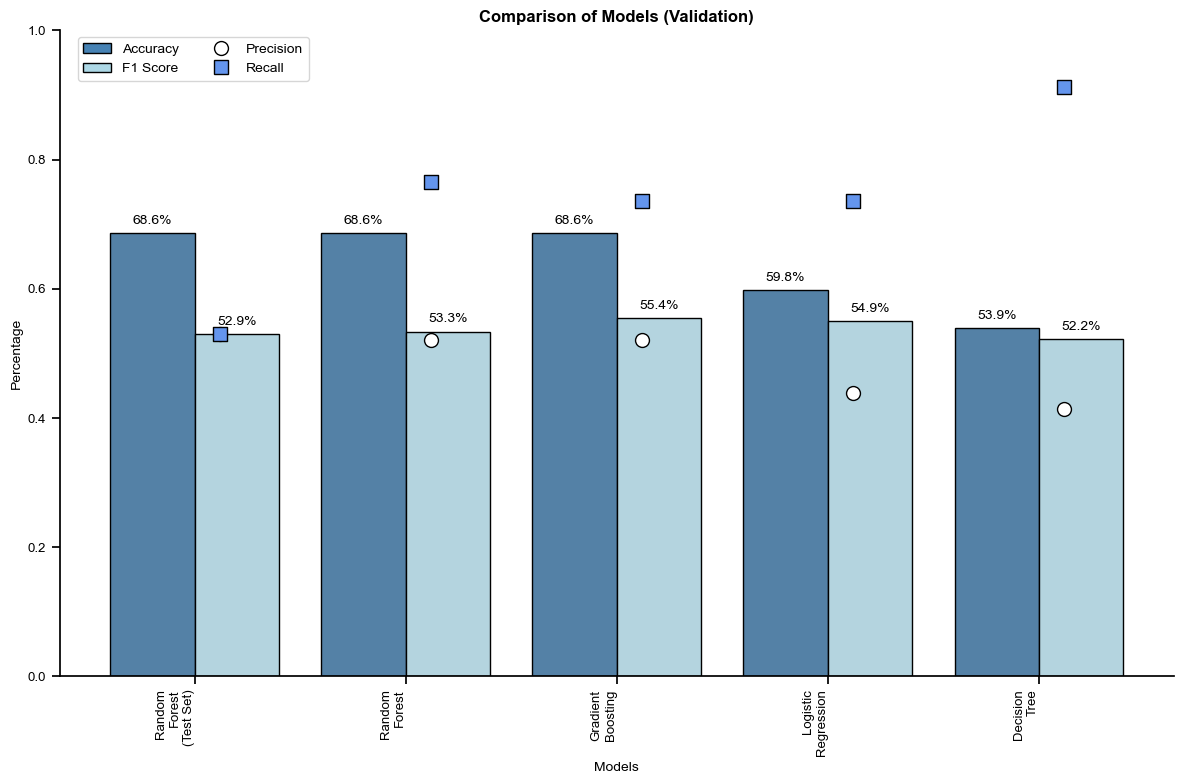

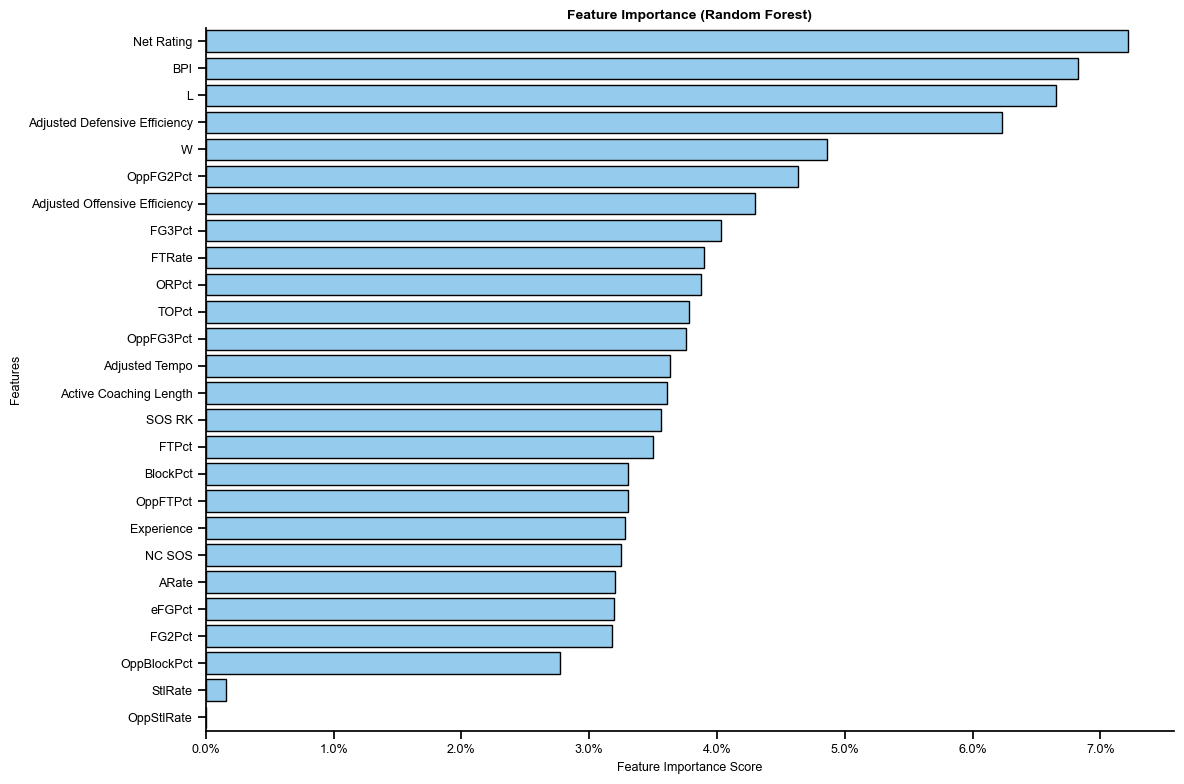

In [70]:
#--------------------------------------------------------------#
                        # Comparison of Models #
#--------------------------------------------------------------#
Models = ['Random Forest (Test Set)', 'Decision Tree', 'Random Forest', 'Gradient Boosting', 'Logistic Regression']
Accuracy = [score_random_forest_test, score_decision_tree_valid, score_random_forest_valid, score_valid, log_accuracy] 
F1_Score = [f1_test, f1_decision_tree, f1_random_forest, f1, log_f1]  
Recall = [rs_random_forest_test, rs_decision_tree, rs_random_forest, best_recall, log_recall]  
Precision = [ps_random_forest_test, ps_decision_tree, ps_random_forest, best_precision, log_precision]  

data = pd.DataFrame({
    'Models': Models,         
    'F1_Score': F1_Score,    
    'Score': Accuracy,       
    'Recall': Recall,          
    'Precision': Precision})

data = data.sort_values(by='Score', ascending=False).reset_index(drop=True)

fig, ax = plt.subplots(figsize=(12, 8))

palette = {
    'Score': 'steelblue',
    'F1_Score': 'lightblue'}
hue_order = ['Score', 'F1_Score']

melted_data = data.melt(
    id_vars=['Models'],
    value_vars=hue_order,
    var_name='Metric',
    value_name='Value')

sns.barplot(
    data=melted_data,
    x='Models',
    y='Value',
    hue='Metric',
    hue_order=hue_order,
    order=data['Models'],
    ax=ax,
    palette=palette,
    edgecolor='black')

group_centers = ax.get_xticks()
bar_width = ax.patches[0].get_width()
f1_positions = group_centers + 0.3 * bar_width

for i, x in enumerate(f1_positions):
    ax.scatter(
        x, data['Precision'].iloc[i],
        color='white', marker='o', edgecolor='black',
        s=100, zorder=5
    )
    ax.scatter(
        x, data['Recall'].iloc[i],
        color='cornflowerblue', marker='s', edgecolor='black',
        s=100, zorder=5)

for p in ax.patches:
    height = p.get_height()  
    if height > 0:
        ax.annotate(
            f'{height * 100:.1f}%',  
            (p.get_x() + p.get_width() / 2, height + 0.01),
            ha='center', va='bottom', fontsize=10, color='black', zorder=6)

ax.set_ylim(0, 1.0)

ax.set_xlabel('Models')
ax.set_ylabel('Performance Metrics')
ax.set_title('Comparison of Models (Validation)', fontsize=12, fontweight='bold')

ax.set_xticklabels(data['Models'], rotation=90, ha='right')

legend_elements = [
    Patch(facecolor=palette['Score'], edgecolor='black', label='Accuracy'),
    Patch(facecolor=palette['F1_Score'], edgecolor='black', label='F1 Score'),
    Line2D([0], [0], marker='o', color='w', label='Precision',
           markerfacecolor='white', markeredgecolor='black', markersize=10),
    Line2D([0], [0], marker='s', color='w', label='Recall',
           markerfacecolor='cornflowerblue', markeredgecolor='black', markersize=10)]
ax.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.12, 1.0), ncol=2, fontsize=10)
ax.set_xticklabels([textwrap.fill(label, width=10) for label in data['Models']], rotation=90, ha='right')


mpl.rcParams["font.family"] = "sans-serif"
mpl.rcParams["font.sans-serif"] = ["Arial", "Helvetica", "DejaVu Sans", "Bitstream Vera Sans"]
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_color('black')
plt.ylabel("Percentage", fontsize=10)
plt.xlabel("Models", fontsize=10)
plt.xticks(fontsize=9.5)
plt.yticks(fontsize=9.5)

ax.grid(False)

plt.tight_layout()
plt.show()

#--------------------------------------------------------------#
                        # Feature of Importance #
#--------------------------------------------------------------#
df_edit = df.drop(['winner', 'team1', 'team2'], axis=1)
feature_importance = model.feature_importances_  # Use the correct attribute here
feature_names = df_edit.columns
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

mpl.rcParams["font.family"] = "sans-serif"
mpl.rcParams["font.sans-serif"] = ["Arial", "Helvetica", "DejaVu Sans", "Bitstream Vera Sans"]

plt.figure(figsize=(12, 8))
ax = plt.gca()

sns.barplot(x='Importance', y='Feature', data=importance_df, color='lightskyblue', edgecolor='black', ax=ax)

plt.xlabel('Feature Importance Score', fontsize=9)
plt.ylabel('Features', fontsize=9)
plt.title('Feature Importance (Random Forest)', fontsize=10, fontweight='bold')

ax.spines['bottom'].set_color('black')
ax.spines['left'].set_color('black')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.xticks(fontsize=9)
plt.yticks(fontsize=9)
ax.xaxis.set_major_formatter(mtick.PercentFormatter(1.0))

ax.grid(False)

plt.tight_layout()
plt.show()

**Model Training and Validation:**

The dataset was first divided into training, validation, and test sets, with the "Winner" column serving as the target variable to differentiate between wins and losses. Given that the features were on different scales, feature scaling was applied to standardize the data.

Subsequently, multiple models—Decision Tree, Random Forest, Logistic Regression, and Gradient Boosting—were trained and evaluated. A loop was used to iterate over various hyperparameters, optimizing each model based on accuracy. In addition, performance metrics such as F1 score, precision, and recall were considered, and class imbalance was handled using a class weight adjustment. The Random Forest model and Gradient Boosting model got tied as the top performer, achieving an accuracy of 68.6% on the validation and test data set. Logistic Regression at 59.8%, and Decision Tree at 53.9%. Random Forest also delivered the highest precision and the second-highest recall, resulting in the second-best F1 score.

To further verify its performance, Random Forest was subjected to cross-validation, which confirmed its robustness by yielding an accuracy of 69% (with an F1 score of 52%), closely matching the 68% accuracy of the best-tuned model. When the optimal hyperparameters were applied to the test set, the results remained consistent at 68%.

A Dummy model was also used as a baseline comparison. Since it did not account for class imbalance, its predictions were skewed towards the majority class, resulting in an accuracy of only 54% and an F1 score of 37%. This underscored the superior performance of the Random Forest model.

#### Bonus Script for Bracket

With the best model we evaluvated being Random Forest, we will build the bracket by taking the team the model predicts. Todo this, matchups are randomized between the 64 teams. Each matchup is fed to the model prediction and the team model predicted is selected for next round in the bracket and the other team is eliminated. This  process is repeated in each round, till there is only one team which is the NCAA winner. With the winners of all the matchups that occured on the randomized bracket the NCAA championship winner is predicted.

In [71]:
import random

# List of 64 teams
teams_list = df_before_feature_engineering['team1'].unique().tolist()

# Randomly shuffle the teams
random.shuffle(teams_list)

# Create a dictionary to store the matchups
matchups = {}

# Create the matchups
for i in range(32):
    matchups[f"Matchup {i+1}"] = (teams_list[i*2], teams_list[i*2+1])

In [72]:
'''
predict_winner function predicts the winning team among the two teams provided
    Input: 
        team_one, team_two - Two teams for the matchup
        lookup_df - Data Frame of all matchup pairs with Aggregated features by subtracting team1 features from the respective Team2 features.
    Returns:
        Returns the name of either team_one or team_two
                
'''
def predict_winner(team_one, team_two, lookup_df):
    team_one_df = lookup_df[lookup_df['team1'] == team_one][:1].drop("team1", axis=1).reset_index(drop=True)
    team_two_df = lookup_df[lookup_df['team1'] == team_two][:1].drop("team1", axis=1).reset_index(drop=True)
    model_test_features = team_one_df.fillna(0) - team_two_df.fillna(0)
    return team_one if model.predict(model_test_features) == 1 else team_two


In [73]:

# Create a dictionary to store the winners
winners = {}
win_loss = df_before_feature_engineering['W-L'].str.split("-")
df_before_feature_engineering['W'] = pd.to_numeric(win_loss.str[0])
df_before_feature_engineering['L'] = pd.to_numeric(win_loss.str[1])

model_columns = ['team1', 'Adjusted Tempo', 'Adjusted Offensive Efficiency',
        'Adjusted Defensive Efficiency', 'eFGPct', 'TOPct', 'ORPct', 'FTRate',
        'FG2Pct', 'FG3Pct', 'FTPct', 'BlockPct', 'OppFG2Pct', 'OppFG3Pct',
        'OppFTPct', 'OppBlockPct', 'ARate', 'StlRate', 'OppStlRate',
        'Experience', 'Net Rating', 'Active Coaching Length', 'W', 'L', 'BPI',
        'SOS RK', 'NC SOS']
model_df = df_before_feature_engineering[model_columns].copy()
round_winners = {}
# Simulate the tournament
for round in range(6):  # 6 rounds: 32, 16, 8, 4, 2, 1
    
    if round == 0:
        for i in range(0,32):
            teams = matchups[f"Matchup {i+1}"]
            round_winners[f"Round {round+1}: Gp {i+1} Winner"] = predict_winner(teams[0], teams[1], model_df)
    else:
        for i in range(int(32/(2**round))):
            teams = [round_winners[f"Round {round}: Gp {i*2+1} Winner"],
                     round_winners[f"Round {round}: Gp {i*2+2} Winner"]
            ]
            round_winners[f"Round {round+1}: Gp {i+1} Winner"] = predict_winner(teams[0], teams[1], model_df)


    

    

In [74]:
round_winners

{'Round 1: Gp 1 Winner': 'Arizona Wildcats',
 'Round 1: Gp 2 Winner': 'Marquette Golden Eagles',
 'Round 1: Gp 3 Winner': 'Iowa State Cyclones',
 'Round 1: Gp 4 Winner': 'BYU Cougars',
 'Round 1: Gp 5 Winner': 'Indiana Hoosiers',
 'Round 1: Gp 6 Winner': 'Utah Utes',
 'Round 1: Gp 7 Winner': "Saint Mary's Gaels",
 'Round 1: Gp 8 Winner': 'Auburn Tigers',
 'Round 1: Gp 9 Winner': 'Duke Blue Devils',
 'Round 1: Gp 10 Winner': 'Ole Miss Rebels',
 'Round 1: Gp 11 Winner': 'Kansas Jayhawks',
 'Round 1: Gp 12 Winner': 'Colorado State Rams',
 'Round 1: Gp 13 Winner': 'Louisville Cardinals',
 'Round 1: Gp 14 Winner': 'Cincinnati Bearcats',
 'Round 1: Gp 15 Winner': 'UC San Diego Tritons',
 'Round 1: Gp 16 Winner': 'Memphis Tigers',
 'Round 1: Gp 17 Winner': 'Arkansas Razorbacks',
 'Round 1: Gp 18 Winner': 'Florida Gators',
 'Round 1: Gp 19 Winner': 'Oklahoma Sooners',
 'Round 1: Gp 20 Winner': 'Baylor Bears',
 'Round 1: Gp 21 Winner': 'Gonzaga Bulldogs',
 'Round 1: Gp 22 Winner': 'Vanderbilt C

In [75]:
### Display the Bracket in order

bracket_df = pd.DataFrame(columns=["teams", "round1", "round2", "round3", "round4", "round5", "round6"])
bracket_df["teams"] = teams_list
bracket_df["round1"] =np.where(
        bracket_df["teams"].isin(
            [round_winners[f"Round 1: Gp {i+1} Winner"] for i in range(32)]
        ),
        "Win-R1",
        "-"
    )
for round in range(2,7):
    bracket_df[f"round{round}"] = np.where(
        bracket_df["teams"].isin(
            [round_winners[f"Round {round}: Gp {i+1} Winner"] for i in range(int(32/2**(round-1)))]
        ),
        f"Win-R{round}",
        "-"
    )
# Set the display option to show all rows
pd.set_option('display.max_rows', None)

bracket_df

,teams,round1,round2,round3,round4,round5,round6
0,St. John's Red Storm,-,-,-,-,-,-
1,Arizona Wildcats,Win-R1,-,-,-,-,-
2,Wisconsin Badgers,-,-,-,-,-,-
3,Marquette Golden Eagles,Win-R1,Win-R2,-,-,-,-
4,Illinois Fighting Illini,-,-,-,-,-,-
5,Iowa State Cyclones,Win-R1,-,-,-,-,-
6,Purdue Boilermakers,-,-,-,-,-,-
7,BYU Cougars,Win-R1,Win-R2,Win-R3,-,-,-
8,New Mexico Lobos,-,-,-,-,-,-
9,Indiana Hoosiers,Win-R1,-,-,-,-,-


In [76]:
# Only the teams in the bracket
bracket_df[bracket_df.apply(lambda row: row.astype(str).str.contains("Win", case=False).any(), axis=1)]

,teams,round1,round2,round3,round4,round5,round6
1,Arizona Wildcats,Win-R1,-,-,-,-,-
3,Marquette Golden Eagles,Win-R1,Win-R2,-,-,-,-
5,Iowa State Cyclones,Win-R1,-,-,-,-,-
7,BYU Cougars,Win-R1,Win-R2,Win-R3,-,-,-
9,Indiana Hoosiers,Win-R1,-,-,-,-,-
11,Utah Utes,Win-R1,Win-R2,-,-,-,-
13,Saint Mary's Gaels,Win-R1,-,-,-,-,-
15,Auburn Tigers,Win-R1,Win-R2,Win-R3,Win-R4,-,-
17,Duke Blue Devils,Win-R1,-,-,-,-,-
19,Ole Miss Rebels,Win-R1,Win-R2,-,-,-,-


Thus 64 teams are reduced into 32-, 16-, 8-, 4-teams, 2-teams and finally 1 team which is our model predicted winner of NCAA Mens Basketball for the 2025 season.

### Conclusion
---

In conclusion, after evaluating multiple models, Random Forest and Gradient Boosting outperformed the other models. The Random Forest Model was quicker compared to Gradient Boosting model, making it the most suitable model for predicting the winner of a matchup pair. This model is further extended to predict the NCAA Mens Basketball Winner for the 2025 season by building the bracket out of randomized matchup.

The Variables Net Rating, BPI that highly correlated to Target Variable Winner during the EDA also took the top spots in Variable importance of the Random Forent Model.

Given this is the MVP Model, it comes with its own limitations such as missing some team matchups as there are no head-to-head matchup for some teams and the number of matchups vary for each teams.

Future recommendation would be to add more enhanced features like near real time information,  player stats and past season match ups, so that the model can predict much more accurately.